# import and functions 

In [126]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import scipy 

def stadardise_data(X, Y):
    """
    Standardizes the input data X and Y.
    """
    X_scaled = StandardScaler().fit_transform(X)
    Y_scaled = StandardScaler().fit_transform(Y)
    return X_scaled, Y_scaled

from sklearn.linear_model import LinearRegression

def plot_canonical_variates(X_c, Y_c,num_variates):
    """
    Plots the canonical variates.
    """
    fig, ax = plt.subplots(1, num_variates, figsize=(20, 5))
    for i in range(num_variates):
        # Correlation between canonical variates
        r, _ = pearsonr(X_c[:, i], Y_c[:, i])
        print(f"Canonical correlation (component {i+1}): {r:.3f}")
        # Plot the canonical variates
        ax[i].scatter(X_c[:, i], Y_c[:, i])
        ax[i].set_xlabel('Replay (Canonical)')
        ax[i].set_ylabel('Behaviour (Canonical)')
        ax[i].set_title(f'r = {r:.2f} component {i+1}')
        
        # Fit regression model
        model = LinearRegression()
        model.fit(X_c[:, i].reshape(-1, 1), Y_c[:, i].reshape(-1, 1))

        # Predict y values
        y_pred = model.predict(X_c[:, i].reshape(-1, 1))

        ax[i].plot(X_c[:, i], y_pred, color='pink', label="Regression line")
        
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# helper: correlation matrix between columns
def _corr_cols(A, B):
    A0 = A - A.mean(axis=0)
    B0 = B - B.mean(axis=0)
    cov = A0.T @ B0 / (A.shape[0] - 1)
    sdA = A0.std(axis=0, ddof=1)
    sdB = B0.std(axis=0, ddof=1)
    return cov / np.outer(sdA, sdB)

def plot_cca_redundancy(X_scaled, Y_scaled, n_components=None):
    n, p = X_scaled.shape
    q = Y_scaled.shape[1]
    k_max = min(p, q, n - 1)
    if n_components is None:
        n_components = k_max
    k = min(n_components, k_max)

    # Fit CCA and get canonical scores
    cca = CCA(n_components=k)
    U, V = cca.fit_transform(X_scaled, Y_scaled)

    # Canonical correlations (sign-align so all positive)
    r = np.array([np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(k)])
    for i in range(k):
        if r[i] < 0:
            V[:, i] *= -1
            r[i] = -r[i]
    r2 = r**2

    # Structure matrices: correlations of originals with their own scores
    Sx = _corr_cols(X_scaled, U)  # (p, k)
    Sy = _corr_cols(Y_scaled, V)  # (q, k)

    # Variance extracted (average squared loading)
    VE_X = (Sx**2).mean(axis=0)
    VE_Y = (Sy**2).mean(axis=0)

    # Redundancy indices
    RED_Y_given_X = VE_Y * r2  # proportion of Y variance explained by X
    RED_X_given_Y = VE_X * r2  # proportion of X variance explained by Y
    
    mean_red = []
    for i in range(k):
        mean_red += [np.mean([RED_X_given_Y[i],RED_Y_given_X[i]])]  # average the two redundancy values for each component

    # Plot
    x = np.arange(1, k + 1)
    plt.figure(figsize=(7, 5))
    plt.plot(x, RED_Y_given_X, marker='o', label='Y (replay features) given X (behaviour features)')
    plt.plot(x, RED_X_given_Y, marker='o', label='X (behaviour features) given Y (replay features)')
    plt.plot(x, mean_red, marker='o', label='Symetric average')
    plt.xlabel('Canonical Component')
    plt.ylabel('Redundancy (proportion explained)')
    plt.title('CCA Redundancy Scree')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return RED_Y_given_X, RED_X_given_Y,mean_red, r

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

def canonical_covariance_share(X_scaled, Y_scaled, n_components, unit_variance=True):
    k_max = min(X_scaled.shape[1], Y_scaled.shape[1], X_scaled.shape[0]-1)
    k = min(n_components, k_max)

    cca = CCA(n_components=k)
    U, V = cca.fit_transform(X_scaled, Y_scaled)  # (n,k), (n,k)

    # Align signs so corr >= 0
    r = np.array([np.corrcoef(U[:, i], V[:, i])[0, 1] for i in range(k)])
    for i in range(k):
        if r[i] < 0:
            V[:, i] *= -1
            r[i] = -r[i]

    if unit_variance:
        # Normalize each score to unit variance so cov == corr
        U = (U - U.mean(axis=0)) / U.std(axis=0, ddof=1)
        V = (V - V.mean(axis=0)) / V.std(axis=0, ddof=1)

    covs = np.array([np.cov(U[:, i], V[:, i], ddof=1)[0, 1] for i in range(k)])
    total = covs.sum()
    props = covs / total if total > 0 else np.zeros_like(covs)

    return props, covs, r

# load in processed data 

In [127]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\processed_data\\"

animals = ['EJT136_1_3','EJT149_1_1','EJT178_1_6','EJT178_1_7','EJT178_1_8','EJT178_2_1','EJT178_2_2','EJT178_2_3','EJT269_1_4','EJT270_1_6','SEQ006_1_8','SEQ006_1_9','SEQ006_1_10','EJT269_1_2','AP5R_1_2','AP5R_1_3','SEQ006_1_1','SEQ006_1_3','SEQ006_1_4','SEQ006_1_5','SEQ006_1_6','SEQ007_1_1','SEQ007_1_2']


In [196]:
delta_behaviour_df = pd.DataFrame()
replay_df = pd.DataFrame()

for animal in animals:
    for file in os.listdir(data_path):
        if animal == '_'.join(file.split('_')[0:3]):
            animal_data_path = data_path + file
            break
    day1_path = None
    day2_path = None
    replay_path = None
    for paths in os.listdir(animal_data_path):
        if 'day1' in paths and not 'png' in paths:
            try:
                day1_path = os.path.join(animal_data_path,paths)
                day1_path =  day1_path + '/processed_tracking_data.csv'
                day1_df = pd.read_csv(day1_path)
            except:
                day1_path = None
        elif 'day2' in paths and not 'png' in paths:
            try:
                day2_path = os.path.join(animal_data_path,paths)
                day2_path =  day2_path + '/processed_tracking_data.csv'
                day2_df = pd.read_csv(day2_path)
            except:
                day2_path = None
        elif 'replay' in paths and not 'replay_unfilt' in paths: 
        # elif 'replay_unfilt' in paths: 
            try:
                replay_path = os.path.join(animal_data_path,paths)
                replay_path =  replay_path + '/processed_replay_features.csv'
                replay_df_current = pd.read_csv(replay_path)
            except:
                replay_path = None
    if day1_path is None or day2_path is None or replay_path is None:
        print(f"Missing data for animal {animal}")
        continue
    else:
        print(f"Found data for animal {animal}: {day1_path}, {day2_path}, {replay_path}")
        
    # load data, compute deltas
    replay_df_current = pd.read_csv(replay_path)
    day1_df = pd.read_csv(day1_path)
    day2_df = pd.read_csv(day2_path)
    if list(day1_df.sequence_motif.values) == list(day2_df.sequence_motif.values):
        delta_df = day2_df.drop(columns = ['mouse_id','sequence_motif']) - day1_df.drop(columns = ['mouse_id','sequence_motif'])
    # concat dataframes
    delta_behaviour_df = pd.concat([delta_behaviour_df, delta_df])
    replay_df = pd.concat([replay_df, replay_df_current])

    



    


Found data for animal EJT136_1_3: Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\processed_data\\EJT136_1_3\day1_11-11-2021/processed_tracking_data.csv, Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\processed_data\\EJT136_1_3\day2_12-11-2021/processed_tracking_data.csv, Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\processed_data\\EJT136_1_3\replay/processed_replay_features.csv
Found data for animal EJT149_1_1: Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\processed_data\\EJT149_1_1\day1_16-11-2021/processed_tracking_data.csv, Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\processed_data\\EJT149_1_1\day2_17-11-2021/processed_tracking_data.csv, Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay

In [195]:
replay_df.animal_id.values

array(['136_1_3', '136_1_3', '136_1_3', '136_1_3', '149_1_1', '149_1_1',
       '149_1_1', '149_1_1', '178_1_6', '178_1_6', '178_1_6', '178_1_6',
       '178_1_6', '178_1_7', '178_1_7', '178_1_7', '178_1_7', '178_1_7',
       '178_1_8', '178_1_8', '178_1_8', '178_1_8', '178_2_1', '178_2_1',
       '178_2_1', '178_2_2', '178_2_2', '178_2_2', '178_2_2', '178_2_3',
       '178_2_3', '178_2_3', '178_2_3', '178_2_3', '269_1_4', '269_1_4',
       '269_1_4', '269_1_4', '269_1_4', '270_1_6', '270_1_6', '270_1_6',
       '270_1_6', '270_1_6', '270_1_6', '270_1_6', '270_1_6', '270_1_6',
       '270_1_6', '270_1_6', '270_1_6', '270_1_6', '270_1_6', '270_1_6',
       '270_1_6', '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2',
       '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2',
       '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2',
       '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2', '269_1_2',
       '269_1_2', '269_1_2', '269_1_2', '269_1_2', 

# prepare dataframes
deal with nans, drops columns, standardise etc. 

In [185]:
# rename columsn and multiply by -1 to make more interpretable
delta_df = pd.DataFrame()
delta_df['change_in_movement_variability'] = delta_behaviour_df['mean_h_distance_from_av_mm_per_motif'] 
delta_df['change_in_movement_speed'] = delta_behaviour_df['mean_movement_speed_mm_s_per_motif']
delta_df['change_in_total_expression'] = delta_behaviour_df['mean_movement_speed_mm_s_per_motif']
# delta_df['change_in_av_distance_to_next_reward'] = delta_behaviour_df['av_distance_to_next_reward_per_motif']
delta_df['change_in_proportion_linked_to_reward'] = delta_behaviour_df['proportion_of_sequences_linked_to_reward_per_motif']
delta_df['change_in_error_rate'] = delta_behaviour_df['error_rate_per_motif']




In [186]:

outcome_matrix = delta_df

predictor_matrix = replay_df.drop(columns = ['animal_id',
                                            'seq_id'])

# if every value in a row is nan, drop that row
mask = predictor_matrix.isna().all(axis=1) | outcome_matrix.isna().all(axis=1)
predictor_matrix = predictor_matrix.loc[~mask]
outcome_matrix   = outcome_matrix.loc[~mask]

# # for this one, nan means there were no reverse. so converting to zero doesnt really make sense.
# # # instead, we will just make it the same as the max value in the column
# max_val = max(predictor_matrix.forward_proportion_compared_to_reverse)
# predictor_matrix.forward_proportion_compared_to_reverse = predictor_matrix.forward_proportion_compared_to_reverse.fillna(max_val)

# convert all nan's, strings and missing values to 0
predictor_matrix = predictor_matrix.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)
outcome_matrix = outcome_matrix.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)

# scale and standardise the data
X_scaled, Y_scaled = stadardise_data(predictor_matrix,outcome_matrix)

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_13908\1374435508.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  predictor_matrix = predictor_matrix.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_13908\1374435508.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  outcome_matrix = outcome_matrix.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)


# CCA - canonical correlation analysis
like PCA but instead of finding reduced dimensions that best describe the variance in the data it compresses the data onto two dimesnions that maximally correlate (one dimension each). You can then look at how each feature weights to each dimensions

1. WORK OUT HOW MANY COMPONENTS

Redundancy in canonical correlation analysis (CCA) is a way of describing how much of one set of variables can be accounted for by the other set through each canonical pair. For a given pair, say $U_i$ (from X) and $V_i$ (from Y), we first measure how well $V_i$ represents Y as a whole by correlating each original Y variable with $V_i$, squaring those correlations, and averaging them—this is the variance extracted from Y. We then multiply this by the squared canonical correlation between $U_i$ and $V_i$, which captures how strongly the X and Y summaries are linked. The result, called redundancy, tells us the proportion of Y’s variance that can be explained from X via that canonical pair (and vice versa for redundancy of X given Y).

How it’s computed (conceptually):

How well does Vᵢ represent Y overall?
Take each original Y variable, correlate it with Vᵢ, square, and average across Y’s variables.
This average is the variance extracted in Y, call it VE_Y(i).

How strongly are the two summaries linked?
Compute the canonical correlation between Uᵢ and Vᵢ; square it → rᵢ².

essentially, you work out how representaitve of the data the Y or X cannonical candiate is for that data. then you multiply this by the squared cannonical correation between X and Y. so its, given how well Y-can explains Y, how much does X-can correlate with Y-can

c:\miniconda\envs\analysis_main\lib\site-packages\sklearn\cross_decomposition\_pls.py:308: UserWarning: y residual is constant at iteration 4
  warnings.warn(f"y residual is constant at iteration {k}")
c:\miniconda\envs\analysis_main\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_13908\1830080295.py:55: RuntimeWarning: invalid value encountered in divide
  return cov / np.outer(sdA, sdB)


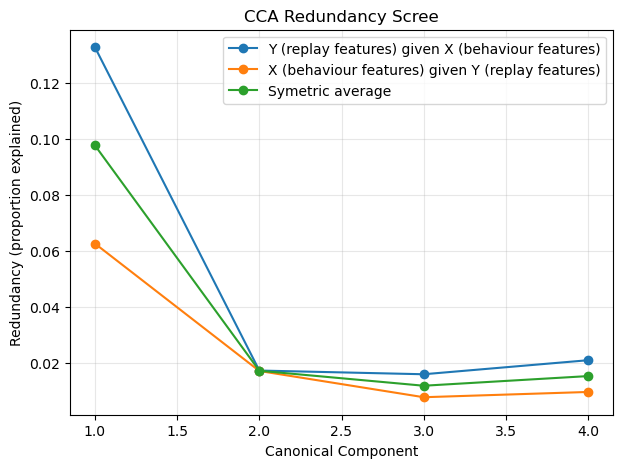

In [187]:
n_components = 100
# n components will max out at the minimum of the number of features in X and Y, or the number of samples minus 1

# Example usage:
RED_YX, RED_XY,mean_red, r = plot_cca_redundancy(X_scaled, Y_scaled, n_components)

cumulative variance explained by the components

(0.0, 0.17)

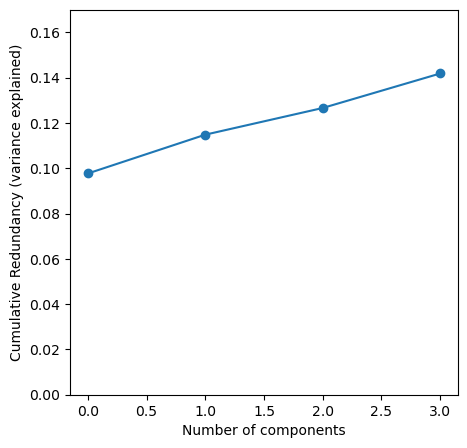

In [188]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.cumsum(mean_red),'-o')
ax.set_xlabel('Number of components')#
ax.set_ylabel('Cumulative Redundancy (variance explained)')
ax.set_ylim(0,round(max(np.cumsum(mean_red)) * 1.2,2))

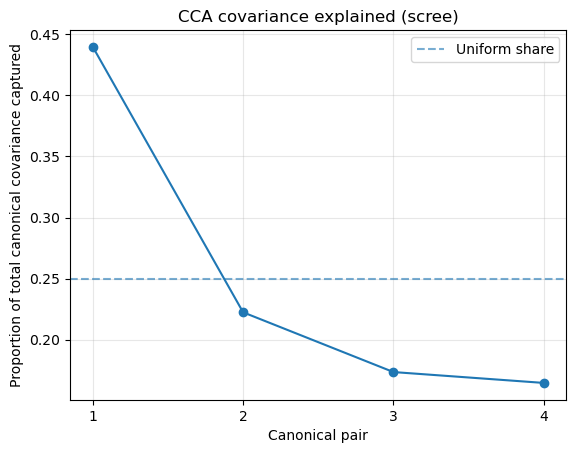

In [189]:
n_components = 4

# --- usage with your variables ---
props, covs, r = canonical_covariance_share(X_scaled, Y_scaled, n_components, unit_variance=True)

# Scree plot
xs = np.arange(1, len(props)+1)
plt.figure()
plt.plot(xs, props, marker='o')
plt.axhline(1/len(props), linestyle='--', alpha=0.6, label='Uniform share')
plt.xticks(xs)
plt.xlabel('Canonical pair')
plt.ylabel('Proportion of total canonical covariance captured')
plt.title('CCA covariance explained (scree)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


make cannonical correlation plots for chosen components

Canonical correlation (component 1): 0.672
Canonical correlation (component 2): 0.340
Canonical correlation (component 3): 0.265


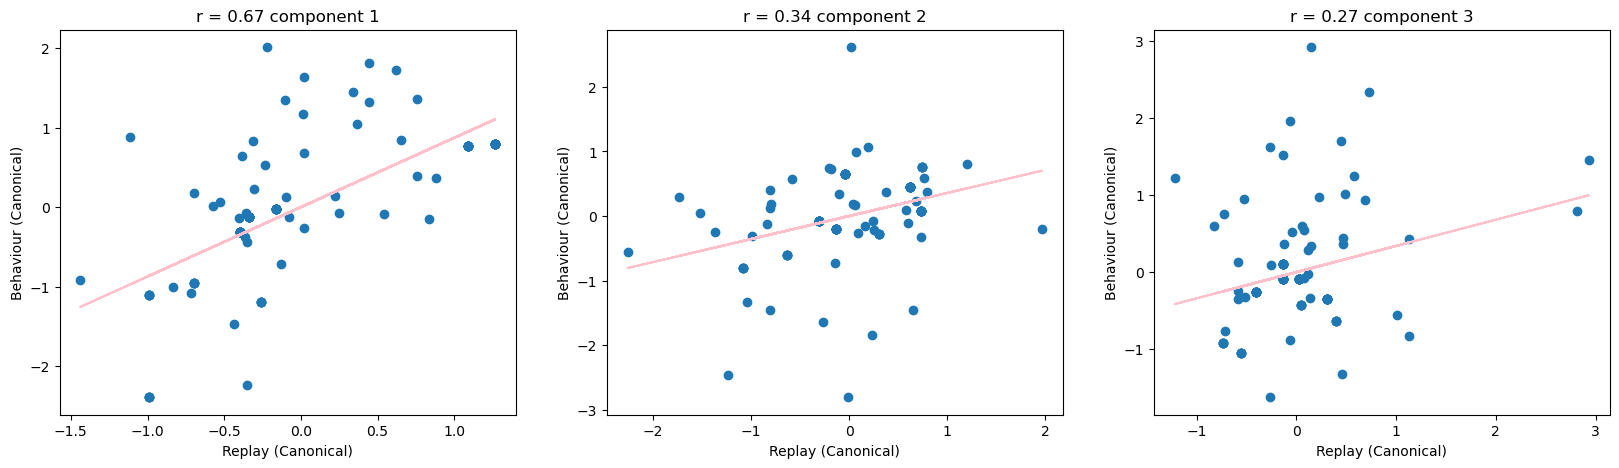

In [190]:
################# RUN CCA Analysis #################
# CCA
n_components= 3
cca = CCA(n_components)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
# Plot canonical variates
plot_canonical_variates(X_c, Y_c,n_components)

            

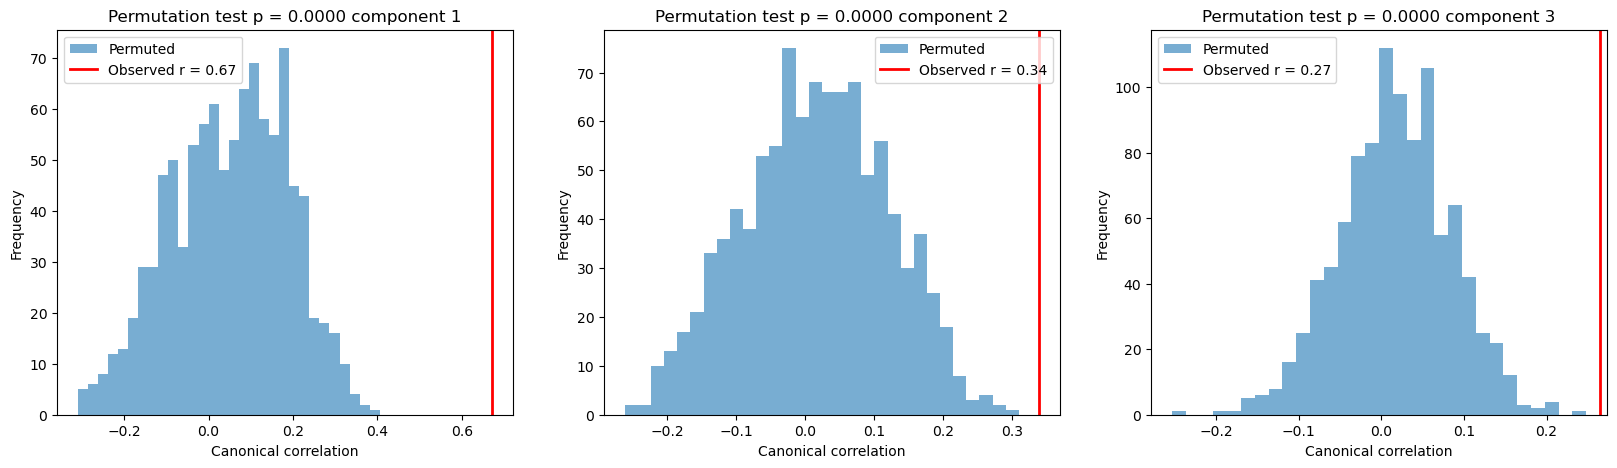

In [191]:

n_perms = 1000
fig, ax = plt.subplots(1, n_components, figsize=(20, 5))
for i in range(n_components):

    perm_r = []
    for _ in range(n_perms):
        Y_perm = np.random.permutation(Y_scaled)
        _, Y_c_perm = cca.fit_transform(X_scaled, Y_perm)
        r_perm, _ = pearsonr(X_c[:, i], Y_c_perm[:, i])
        perm_r.append(r_perm)

    # True correlation
    X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
    
    r_true, _ = pearsonr(X_c[:, i], Y_c[:, i])

    p_val = np.mean(np.array(perm_r) >= r_true)


    ax[i].hist(perm_r, bins=30, alpha=0.6, label='Permuted')
    ax[i].axvline(r_true, color='red', linewidth=2, label=f'Observed r = {r_true:.2f}')
    ax[i].set_xlabel("Canonical correlation")
    ax[i].set_ylabel("Frequency")
    ax[i].set_title(f"Permutation test p = {p_val:.4f} component {i+1}")
    ax[i].legend()

extract the feature weights and bootstrap the data to get error bars

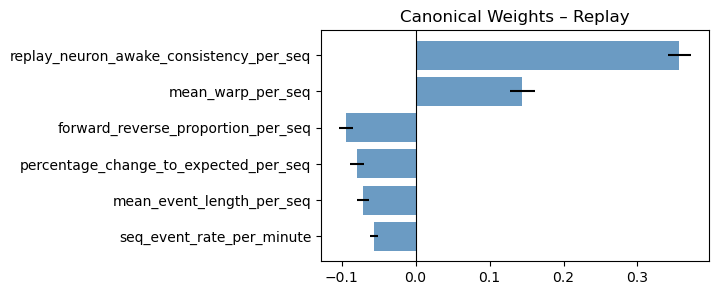

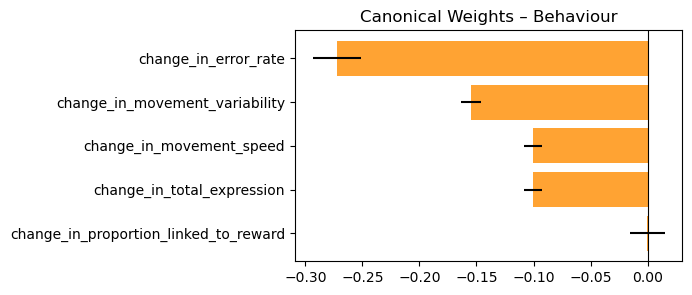

In [192]:
# --- Step 1: Standardize ---
X = predictor_matrix
Y = outcome_matrix

# --- Step 2: Fit CCA on full data ---
cca = CCA(n_components=n_components)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)


x_weights = cca.x_weights_[:, 0]
y_weights = cca.y_weights_[:, 0]

# --- Step 3: Bootstrap ---
n_boots = 1000
x_weights_all = np.zeros((n_boots, X.shape[1]))
y_weights_all = np.zeros((n_boots, Y.shape[1]))

for i in range(n_boots):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    X_boot = X_scaled[idx]
    Y_boot = Y_scaled[idx]
    
    cca.fit(X_boot, Y_boot)
    x_weights_all[i] = cca.x_weights_[:, 0]
    y_weights_all[i] = cca.y_weights_[:, 0]

# --- Step 4: Compute confidence intervals ---
x_mean = x_weights_all.mean(axis=0)
y_mean = y_weights_all.mean(axis=0)

x_err = scipy.stats.sem(x_weights_all, axis=0)
y_err = scipy.stats.sem(y_weights_all, axis=0)

# Sort by absolute weight magnitude
sorted_idx_x = np.argsort(np.abs(x_mean))
sorted_idx_y = np.argsort(np.abs(y_mean))

# Behaviour
beh_names = np.array(X.columns)[sorted_idx_x]
beh_vals = x_mean[sorted_idx_x]

# Replay
rep_names = np.array(Y.columns)[sorted_idx_y]
rep_vals = y_mean[sorted_idx_y]

# Plot
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

axes.barh(beh_names, beh_vals, xerr= x_err, color='steelblue', alpha=0.8)
axes.set_title('Canonical Weights – Replay')
axes.axvline(0, color='black', linewidth=0.8)

fig, axes = plt.subplots(1, 1, figsize=(5, 3))
axes.barh(rep_names, rep_vals, xerr=y_err, color='darkorange', alpha=0.8)
axes.set_title('Canonical Weights – Behaviour')
axes.axvline(0, color='black', linewidth=0.8)

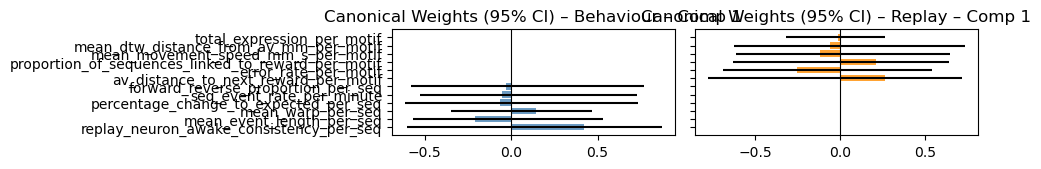

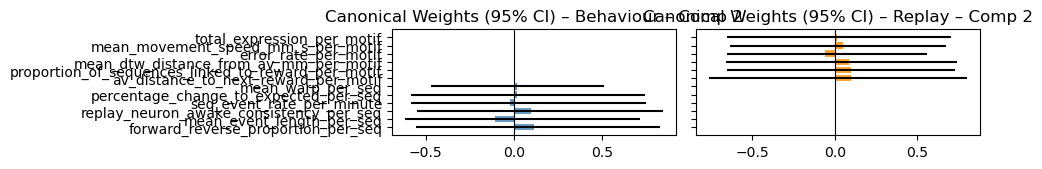

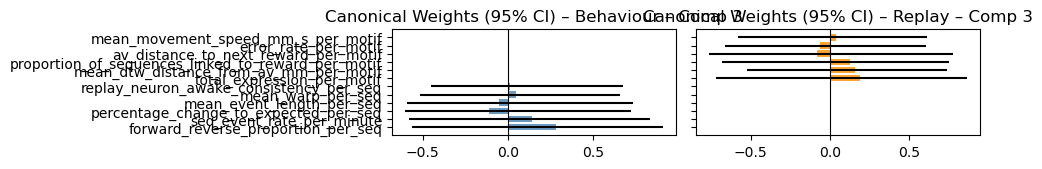

In [95]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA


def bootstrap_cca(X, Y,predictor_matrix,outcome_matrix, n_components=2, n_boots=1000, random_state=None):
    """
    Fits CCA and bootstraps canonical weights for all components.

    Returns:
        x_summary: list of DataFrames (one per component) for X weights
        y_summary: list of DataFrames (one per component) for Y weights
    """
    rng = np.random.default_rng(random_state)
    cca = CCA(n_components=n_components)

    # Fit full model
    cca.fit(X, Y)
    x_full = cca.x_weights_   # shape: (n_features_X, n_components)
    y_full = cca.y_weights_   # shape: (n_features_Y, n_components)

    # Storage for bootstrapped weights
    x_boots = np.zeros((n_boots, X.shape[1], n_components))
    y_boots = np.zeros((n_boots, Y.shape[1], n_components))

    for i in range(n_boots):
        idx = rng.choice(len(X), size=len(X), replace=True)
        cca.fit(X[idx], Y[idx])
        x_boots[i] = cca.x_weights_
        y_boots[i] = cca.y_weights_

    # Build summaries per component
    x_summary, y_summary = [], []
    for comp in range(n_components):
        x_mean = x_boots[:, :, comp].mean(axis=0)
        x_ci_low, x_ci_high = np.percentile(x_boots[:, :, comp], [2.5, 97.5], axis=0)

        y_mean = y_boots[:, :, comp].mean(axis=0)
        y_ci_low, y_ci_high = np.percentile(y_boots[:, :, comp], [2.5, 97.5], axis=0)

        df_x = pd.DataFrame({
            "feature": predictor_matrix.columns,
            "mean": x_mean,
            "ci_low": x_ci_low,
            "ci_high": x_ci_high
        }).sort_values("mean", key=np.abs, ascending=False)

        df_y = pd.DataFrame({
            "feature": outcome_matrix.columns,
            "mean": y_mean,
            "ci_low": y_ci_low,
            "ci_high": y_ci_high
        }).sort_values("mean", key=np.abs, ascending=False)

        x_summary.append(df_x)
        y_summary.append(df_y)

    return x_summary, y_summary


def plot_cca_weights(x_summary, y_summary):
    """
    Plots canonical weights with CIs for each component.
    """
    n_components = len(x_summary)
    for comp in range(n_components):
        fig, axes = plt.subplots(1, 2, figsize=(10, 0.3 * max(len(x_summary[comp]), len(y_summary[comp]))), sharey=True)

        axes[0].barh(x_summary[comp]["feature"], x_summary[comp]["mean"],
                     xerr=[x_summary[comp]["mean"] - x_summary[comp]["ci_low"],
                           x_summary[comp]["ci_high"] - x_summary[comp]["mean"]],
                     color="steelblue", alpha=0.8)
        axes[0].set_title(f'Canonical Weights (95% CI) – Behaviour – Comp {comp+1}')
        axes[0].axvline(0, color='black', linewidth=0.8)

        axes[1].barh(y_summary[comp]["feature"], y_summary[comp]["mean"],
                     xerr=[y_summary[comp]["mean"] - y_summary[comp]["ci_low"],
                           y_summary[comp]["ci_high"] - y_summary[comp]["mean"]],
                     color="darkorange", alpha=0.8)
        axes[1].set_title(f'Canonical Weights (95% CI) – Replay – Comp {comp+1}')
        axes[1].axvline(0, color='black', linewidth=0.8)

        plt.tight_layout()
        plt.show()


# Example usage:
# X_scaled, Y_scaled are your standardized predictor/outcome matrices
n_components = 3
x_summary, y_summary = bootstrap_cca(X_scaled, Y_scaled,predictor_matrix,outcome_matrix, n_components=n_components, n_boots=1000, random_state=42)
plot_cca_weights(x_summary, y_summary)


In [39]:
np.corrcoef(X_scaled, rowvar=False)

array([[ 1.        ,  0.46228867, -0.10272626,  0.15994029,  0.45898927,
         0.64290658],
       [ 0.46228867,  1.        , -0.09333341,  0.36165277,  0.90609957,
         0.6279734 ],
       [-0.10272626, -0.09333341,  1.        ,  0.25696862, -0.08931094,
         0.13477122],
       [ 0.15994029,  0.36165277,  0.25696862,  1.        ,  0.27443423,
         0.30091364],
       [ 0.45898927,  0.90609957, -0.08931094,  0.27443423,  1.        ,
         0.6203955 ],
       [ 0.64290658,  0.6279734 ,  0.13477122,  0.30091364,  0.6203955 ,
         1.        ]])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.495048,1.056290,-1.244946,-1.352466,0.349879,-0.411269,-1.072169,0.690302,-0.334848,-1.715807,0.883807,-0.110994,0.975298
1,-0.567318,-0.802610,0.453225,0.992685,-0.272848,-0.789367,0.010504,-0.723011,-0.334848,1.255560,0.990442,0.882109,0.726830
2,-0.268214,0.045538,-1.235820,0.000755,1.192157,1.590723,1.093896,1.067051,-0.334848,0.329420,0.227266,1.395210,-0.112127
3,0.268013,0.650195,-0.156623,0.961242,0.790410,1.864448,-0.809859,1.027880,-0.334848,1.062614,0.995698,0.492636,1.014624
4,-0.527622,-0.540998,-0.354210,-0.340172,0.441898,0.105651,-0.425693,0.461701,-0.334848,-1.157079,-0.622300,-0.648472,1.521722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,-0.273748,1.878410,-0.802423,0.443418,-0.868684,0.524969,-0.478159,-0.751439,-0.334848,0.823455,-0.622300,-0.648472,-0.988785
78,-1.227243,-0.635376,0.979152,-0.637288,-1.153902,-0.935956,-0.889281,-1.419778,-0.334848,0.082336,-0.622300,-0.648472,-1.086854
79,-0.032562,2.194991,-0.257644,-1.119364,-0.970167,0.065911,-0.025700,0.662995,-0.334848,-1.018684,-0.622300,-0.648472,-1.165674
80,-0.936058,-0.437271,-0.261904,0.551958,0.344235,2.296666,0.975488,1.166690,-0.334848,0.684780,-0.622300,-0.648472,-0.504024


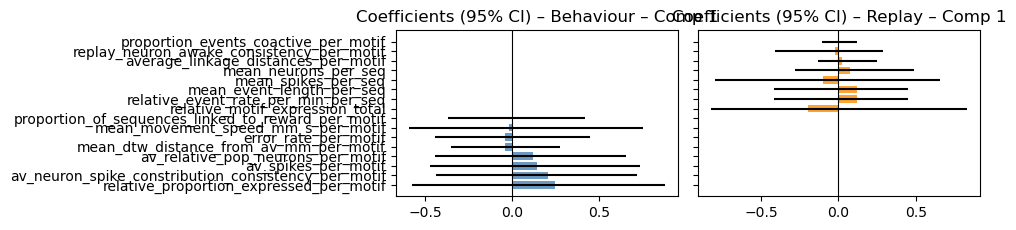

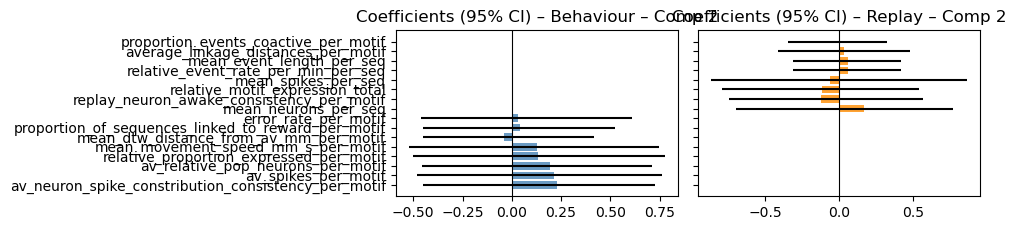

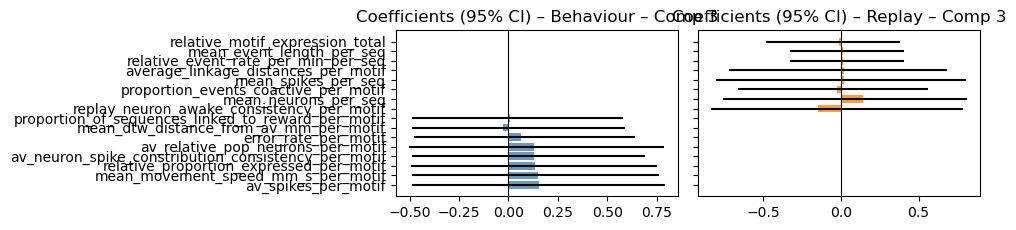

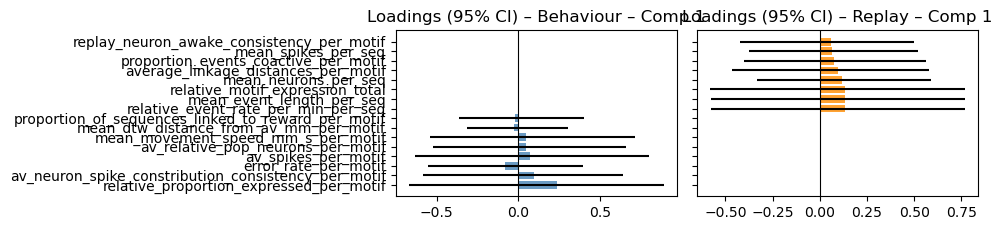

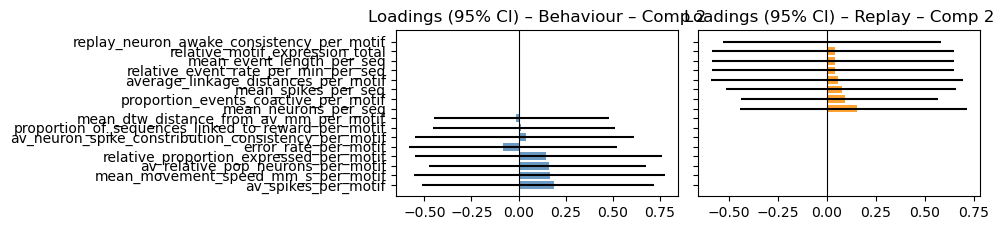

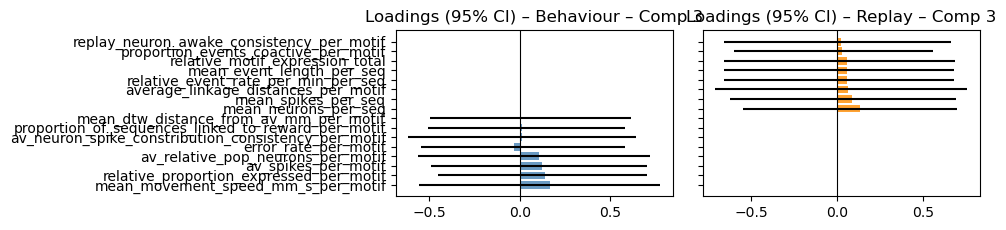

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA


def bootstrap_cca_with_loadings(X, Y,predictor_matrix,outcome_matrix,n_components=2, n_boots=1000, random_state=None):
    """
    Fits CCA and bootstraps both canonical coefficients and loadings for all components.
    
    Returns:
        results_x, results_y: dicts with:
            - 'coefficients': list of DataFrames (per component)
            - 'loadings': list of DataFrames (per component)
    """
    rng = np.random.default_rng(random_state)
    cca = CCA(n_components=n_components)

    # Fit full model on entire dataset
    cca.fit(X, Y)
    U_full, V_full = cca.transform(X, Y)

    # Compute loadings for full data
    loadings_x_full = np.array([
        np.corrcoef(X[:, j], U_full, rowvar=False)[0, 1:]
        for j in range(X.shape[1])
    ])
    loadings_y_full = np.array([
        np.corrcoef(Y[:, j], V_full, rowvar=False)[0, 1:]
        for j in range(Y.shape[1])
    ])

    # Storage arrays
    coef_x_boots = np.zeros((n_boots, X.shape[1], n_components))
    coef_y_boots = np.zeros((n_boots, Y.shape[1], n_components))
    load_x_boots = np.zeros((n_boots, X.shape[1], n_components))
    load_y_boots = np.zeros((n_boots, Y.shape[1], n_components))

    for i in range(n_boots):
        idx = rng.choice(len(X), size=len(X), replace=True)
        cca.fit(X[idx], Y[idx])
        U, V = cca.transform(X[idx], Y[idx])

        coef_x_boots[i] = cca.x_weights_
        coef_y_boots[i] = cca.y_weights_

        for j in range(X.shape[1]):
            load_x_boots[i, j, :] = [
                np.corrcoef(X[idx, j], U[:, k])[0, 1]
                for k in range(n_components)
            ]
        for j in range(Y.shape[1]):
            load_y_boots[i, j, :] = [
                np.corrcoef(Y[idx, j], V[:, k])[0, 1]
                for k in range(n_components)
            ]

    # Helper to summarise bootstrap results
    def summarize_bootstrap(boot_array, feature_names):
        summaries = []
        for comp in range(n_components):
            means = boot_array[:, :, comp].mean(axis=0)
            ci_low = np.percentile(boot_array[:, :, comp], 2.5, axis=0)
            ci_high = np.percentile(boot_array[:, :, comp], 97.5, axis=0)
            df = pd.DataFrame({
                "feature": feature_names,
                "mean": means,
                "ci_low": ci_low,
                "ci_high": ci_high
            }).sort_values("mean", key=np.abs, ascending=False)
            summaries.append(df)
        return summaries


    results_x = {
        "coefficients": summarize_bootstrap(coef_x_boots, predictor_matrix.columns),
        "loadings": summarize_bootstrap(load_x_boots, predictor_matrix.columns)
    }
    results_y = {
        "coefficients": summarize_bootstrap(coef_y_boots, outcome_matrix.columns),
        "loadings": summarize_bootstrap(load_y_boots, outcome_matrix.columns)
    }

    return results_x, results_y


def plot_cca_results(results_x, results_y, kind="coefficients"):
    """
    Plots coefficients or loadings for all components.
    kind: "coefficients" or "loadings"
    """
    n_components = len(results_x[kind])
    for comp in range(n_components):
        fig, axes = plt.subplots(1, 2, figsize=(10, 0.3 * max(
            len(results_x[kind][comp]), len(results_y[kind][comp])
        )), sharey=True)

        for ax, df, color, title in zip(
            axes,
            [results_x[kind][comp], results_y[kind][comp]],
            ["steelblue", "darkorange"],
            [f"Behaviour – Comp {comp+1}", f"Replay – Comp {comp+1}"]
        ):
            ax.barh(df["feature"], df["mean"],
                    xerr=[df["mean"] - df["ci_low"], df["ci_high"] - df["mean"]],
                    color=color, alpha=0.8)
            ax.set_title(f"{kind.capitalize()} (95% CI) – {title}")
            ax.axvline(0, color="black", linewidth=0.8)

        plt.tight_layout()
        plt.show()


# Example usage:
results_x, results_y = bootstrap_cca_with_loadings(X_scaled, Y_scaled,predictor_matrix,outcome_matrix, n_components=3, n_boots=1000, random_state=42)
plot_cca_results(results_x, results_y, kind="coefficients")  # to plot coefficients
plot_cca_results(results_x, results_y, kind="loadings")      # to plot loadings


In [96]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from scipy.stats import norm


def cca_stability_selection(
    X, Y, n_components=2, n_resamples=1000, ci_level=0.95, random_state=None
):
    """
    Performs stability selection for CCA features using 2/3 + 1/3 resampling,
    component matching, and CI exclusion from zero.

    Args:
        X, Y: np.ndarray or pd.DataFrame (standardized data)
        n_components: number of canonical variates
        n_resamples: number of resamples
        ci_level: confidence level (0.95 = 95% CI)
        random_state: optional integer for reproducibility

    Returns:
        results_x, results_y: lists of DataFrames (per component) with:
            - mean
            - ci_low, ci_high
            - stable (bool)
    """
    rng = np.random.default_rng(random_state)

    # Convert to numpy if DataFrame
    X_np = X.values if hasattr(X, "values") else np.array(X)
    Y_np = Y.values if hasattr(Y, "values") else np.array(Y)
    feature_names_X = X.columns if hasattr(X, "columns") else [f"X{i}" for i in range(X_np.shape[1])]
    feature_names_Y = Y.columns if hasattr(Y, "columns") else [f"Y{i}" for i in range(Y_np.shape[1])]

    # Fit original CCA
    cca = CCA(n_components=n_components)
    cca.fit(X_np, Y_np)
    U_orig, V_orig = cca.transform(X_np, Y_np)

    # Storage
    boot_coefs_X = np.zeros((n_resamples, X_np.shape[1], n_components))
    boot_coefs_Y = np.zeros((n_resamples, Y_np.shape[1], n_components))

    for i in range(n_resamples):
        # --- 2/3 random selection ---
        idx_train = rng.choice(len(X_np), size=int(len(X_np) * (1 / 3)), replace=False)
        X_train, Y_train = X_np[idx_train], Y_np[idx_train]

        # --- 1/3 replacement from the train set ---
        idx_replace = rng.choice(idx_train, size=len(X_np) - len(idx_train), replace=True)
        idx_resample = np.concatenate([idx_train, idx_replace])
        X_boot, Y_boot = X_np[idx_resample], Y_np[idx_resample]

        # --- Fit bootstrap CCA ---
        cca.fit(X_boot, Y_boot)
        U_boot, V_boot = cca.transform(X_boot, Y_boot)

        # --- Match components to original by correlation ---
        for comp_boot in range(n_components):
            corrs = [abs(np.corrcoef(U_boot[:, comp_boot], U_orig[:, comp_orig])[0, 1])
                     for comp_orig in range(n_components)]
            match_comp = np.argmax(corrs)

            # Sign alignment
            sign_flip = np.sign(np.corrcoef(U_boot[:, comp_boot], U_orig[:, match_comp])[0, 1])
            boot_coefs_X[i, :, match_comp] = cca.x_weights_[:, comp_boot] * sign_flip
            boot_coefs_Y[i, :, match_comp] = cca.y_weights_[:, comp_boot] * sign_flip

    # Helper to summarise results
    def summarise_bootstrap(boot_array, feature_names):
        summaries = []
        z_score = norm.ppf(0.5 + ci_level / 2)
        for comp in range(n_components):
            mean_vals = boot_array[:, :, comp].mean(axis=0)
            ci_low = np.percentile(boot_array[:, :, comp], (1 - ci_level) / 2 * 100, axis=0)
            ci_high = np.percentile(boot_array[:, :, comp], (1 + ci_level) / 2 * 100, axis=0)
            stable = (ci_low > 0) | (ci_high < 0)  # CI does not cross zero

            df = pd.DataFrame({
                "feature": feature_names,
                "mean": mean_vals,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "stable": stable
            }).sort_values("mean", key=np.abs, ascending=False)
            summaries.append(df)
        return summaries

    results_x = summarise_bootstrap(boot_coefs_X, feature_names_X)
    results_y = summarise_bootstrap(boot_coefs_Y, feature_names_Y)

    return results_x, results_y


# Example usage:
results_x, results_y = cca_stability_selection(X_scaled, Y_scaled, n_components=3, n_resamples=1000, ci_level=0.95, random_state=1)
# Now `results_x[0]` is the table for component 1 (predictors), etc.


In [176]:
results_x[0]

,feature,mean,ci_low,ci_high,stable
5,X5,0.018450,-0.661445,0.707822,False
4,X4,-0.011962,-0.671422,0.649394,False
1,X1,0.008763,-0.674718,0.651805,False
7,X7,0.005194,-0.567819,0.616898,False
6,X6,0.005046,-0.580875,0.621226,False
0,X0,0.005004,-0.696372,0.675647,False
3,X3,-0.004249,-0.491269,0.457244,False
2,X2,0.001897,-0.579495,0.610279,False
